# Setup

In [ ]:
!git clone https://github.com/timesler/facenet-pytorch.git facenet_pytorch

In [ ]:
%cd /content/facenet_pytorch 

In [ ]:
!pip install mmcv
!pip install opencv-python

# Face detection and recognition

In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import pandas as pd
import os

workers = 0 if os.name == 'nt' else 4

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

In [3]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [4]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

In [ ]:
def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder('data/test_images')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

In [ ]:
aligned = []
names = []
for x, y in loader:
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        print('Face detected with probability: {:8f}'.format(prob))
        aligned.append(x_aligned)
        names.append(dataset.idx_to_class[y])

In [9]:
aligned = torch.stack(aligned).to(device)
embeddings = resnet(aligned).detach().cpu()

In [ ]:
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in embeddings]
print(pd.DataFrame(dists, columns=names, index=names))

# Face tracking

In [5]:
from facenet_pytorch import MTCNN
import torch
import numpy as np
import mmcv, cv2
from PIL import Image, ImageDraw
from IPython import display

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

In [7]:
mtcnn = MTCNN(keep_all=True, device=device)

need some video, (e.g. https://www.pexels.com/video/video-of-people-walking-855564/)

In [8]:

video = mmcv.VideoReader('examples/video.mp4')
frames = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in video]

# display.Video('examples/video.mp4', width=640)

In [ ]:
frames_tracked = []
for i, frame in enumerate(frames):
    print('\rTracking frame: {}'.format(i + 1), end='')
    
    # Detect faces
    boxes, _ = mtcnn.detect(frame)
    
    # Draw faces
    frame_draw = frame.copy()
    draw = ImageDraw.Draw(frame_draw)
    for box in boxes:
        draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)
    
    # Add to frame list
    frames_tracked.append(frame_draw.resize((640, 360), Image.BILINEAR))
print('\nDone')

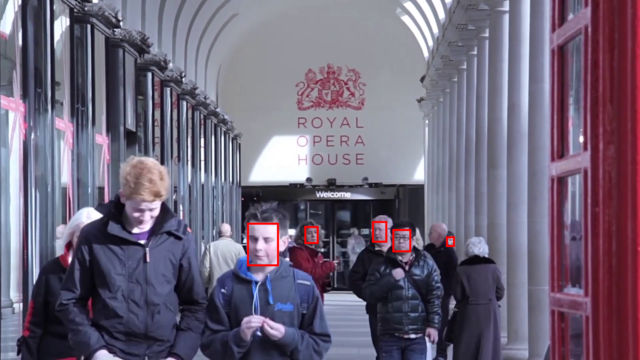

In [11]:
d = display.display(frames_tracked[0], display_id=True)
i = 1
try:
    while True:
        d.update(frames_tracked[i % len(frames_tracked)])
        i += 1
except KeyboardInterrupt:
    pass

In [10]:
dim = frames_tracked[0].size
fourcc = cv2.VideoWriter_fourcc(*'FMP4')    
video_tracked = cv2.VideoWriter('video_tracked.mp4', fourcc, 25.0, dim)
for frame in frames_tracked:
    video_tracked.write(cv2.cvtColor(np.array(frame), cv2.COLOR_RGB2BGR))
video_tracked.release()